In [ ]:
from google.colab import drive

# 1. Google Drive 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. 파일 경로 설정 (사용자 지정 경로)
data_root = '/content/drive/MyDrive/Colab Notebooks/datathon'
# file_path = f'{data_root}/2019-Nov.csv'

#데이터 불러오기 + 기본 전처리

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [ ]:
sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 파일 경로 지정
font_path = '/content/drive/MyDrive/font/NanumGothic.ttf'

# 폰트 등록 및 matplotlib 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [ ]:
df = pd.read_csv(f'{data_root}/2019-Nov.csv')
# df.info()

In [ ]:
# 전체 결측치 수 및 비율 확인
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_summary = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
missing_summary

In [ ]:
# datetime 형식으로 되어 있어야 함
df['event_time'] = pd.to_datetime(df['event_time'])

# 날짜, 시간 파생 -> 일자별 트렌드, 리텐션, 시계열 그래프 or 시간대별 유입/이탈 분석, 마케팅 시간 설정 가능
# event_date를 datetime으로 변환 (안정성 확보)
df['event_date'] = pd.to_datetime(df['event_time'].dt.date)

# 시간 컬럼 생성 (00시 단위까지만)
df['event_hour'] = df['event_time'].dt.hour

In [ ]:
# .으로 나눈 컬럼 생성 (최대 4단계까지 가정)
category_split = df['category_code'].str.split('.', expand=True)

# 새로운 컬럼 이름 지정
category_split.columns = ['category_lvl1', 'category_lvl2', 'category_lvl3', 'category_lvl4']

# 기존 df에 병합
df = pd.concat([df, category_split], axis=1)

In [ ]:
# 정렬
df = df.sort_values(by=['user_id', 'event_time'])

In [ ]:
# event_type 컬럼의 고유값 확인

df['event_type'].unique()

array(['view', 'cart', 'purchase'], dtype=object)

In [ ]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_hour,category_lvl1,category_lvl2,category_lvl3,category_lvl4
8425249,2019-11-06 06:51:52+00:00,view,26300219,2053013563424899933,NaN,sokolov,40.54,10300217,d1fdcbf1-bb1f-434b-8f1a-4b77f29a84a0,2019-11-06,6,NaN,NaN,NaN,NaN
15378293,2019-11-10 02:08:39+00:00,view,13200917,2053013557192163841,furniture.bedroom.bed,NaN,514.81,29515875,5dd49822-9349-42d6-a165-cd4642ee606b,2019-11-10,2,furniture,bedroom,bed,None
15381235,2019-11-10 02:14:40+00:00,view,13201002,2053013557192163841,furniture.bedroom.bed,stendmebel,176.04,29515875,eb6882fb-ead2-47a5-aa86-d171a2c3b6ff,2019-11-10,2,furniture,bedroom,bed,None
19418807,2019-11-12 03:42:01+00:00,view,13200917,2053013557192163841,furniture.bedroom.bed,NaN,514.81,29515875,1552ef43-4001-4ab7-a9c7-44e99f1730a9,2019-11-12,3,furniture,bedroom,bed,None
19418937,2019-11-12 03:42:06+00:00,view,13200917,2053013557192163841,furniture.bedroom.bed,NaN,514.81,29515875,1552ef43-4001-4ab7-a9c7-44e99f1730a9,2019-11-12,3,furniture,bedroom,bed,None


In [ ]:
# 전체 결측치 수 및 비율 확인
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_summary = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
missing_summary

,Missing Count,Missing %
brand,9224078,13.664900
category_code,21898171,32.440784
category_id,0,0.000000
category_lvl1,21898171,32.440784
category_lvl2,21898171,32.440784
category_lvl3,48685506,72.124561
category_lvl4,67438640,99.906167
event_date,0,0.000000
event_hour,0,0.000000
event_time,0,0.000000


In [ ]:
# user_session이 결측치인 행만 필터링
missing_session = df[df['user_session'].isnull()]

# 해당 행들의 event_type 분포 확인 -> cart 라서 빼도 될 듯
missing_session['event_type'].value_counts()

,count
event_type,
cart,10


In [ ]:
# 1. 구매 이벤트만 추출
purchase_df = df[df['event_type'] == 'purchase'].copy()

# 2. user_id별 구매 횟수 계산
purchase_counts = purchase_df.groupby('user_id').size().reset_index(name='purchase_count')

# 3. 정확히 1회 구매한 유저 추출(6개월치 데이터로 구매 주기 추적 위해)
one_time_buyers = purchase_counts[purchase_counts['purchase_count'] == 1]

# 4. 구매 1회 유저의 구매 로그만 추출
one_time_purchase_df = purchase_df[purchase_df['user_id'].isin(one_time_buyers['user_id'])].copy()

# 5. user_id 중복 여부 확인
has_duplicates = one_time_purchase_df['user_id'].duplicated().any()

# 6. 결과 출력
print(f"🎯 한 번만 구매한 고객 수: {len(one_time_buyers):,}명")
print(f"✅ 중복 user_id 존재 여부: {has_duplicates}")

🎯 한 번만 구매한 고객 수: 273,246명
✅ 중복 user_id 존재 여부: False


In [ ]:
# 1. CSV 파일로 저장 (파일명은 원하는 대로 지정 가능)
one_time_purchase_df.to_csv('one_time_purchase_users.csv', index=False)

# 2. 다운로드 링크 생성
from google.colab import files
files.download('one_time_purchase_users.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#EDA

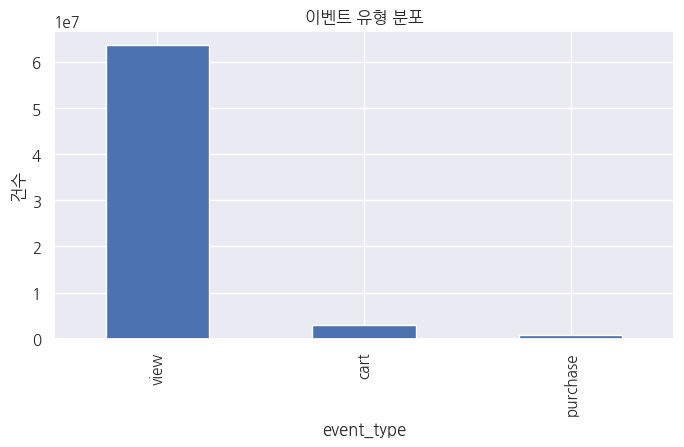

In [ ]:
# 이벤트 유형 분포 확인
df['event_type'].value_counts().plot(kind='bar', title='이벤트 유형 분포', figsize=(8,4))
plt.xlabel('event_type'); plt.ylabel('건수')
plt.show()


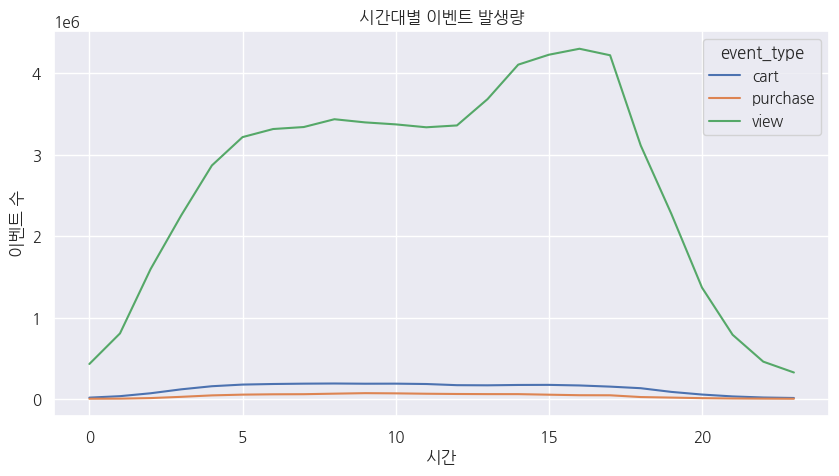

In [ ]:
# 시간대별 사용자 행동
hourly = df.groupby(['event_hour', 'event_type']).size().unstack()
hourly.plot(kind='line', figsize=(10,5), title='시간대별 이벤트 발생량')
plt.xlabel('시간'); plt.ylabel('이벤트 수')
plt.show()


#신규 고객 정의 및 행동 분석